## Objective: Classifying Cyberbullying in Tweets

Our objective is to build a Recurrent Neural Network (RNN) that can accurately classify cyberbullying by type in text. Our model will be trained on 6 categories of cyberbullying (5 types of cyberbullying and 1 category representing "not cyberbullying" making this a multiclassification problem.

### Content Warning 

Please note that due to the nature of this problem you may encounter troubling and offensive language including slurs. At some points in the notebook there are procedural checks to confirm text processing which samples from the training data and so may randomly include offensive material. 


In [1]:
## Import Libraries

import numpy as np
import np_utils
import pandas as pd

import tensorflow as tf
import keras

import sklearn
from sklearn.preprocessing import LabelEncoder

import nltk
from nltk.corpus import stopwords

keras.utils.set_random_seed(8122) ## for reproducability

#Data Viz
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from keras.layers import Embedding, GRU, Bidirectional, LSTM, Dense, Dropout, TextVectorization

import keras_tuner

#Optimizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

#Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

2024-01-30 11:17:38.094925: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## About the Data

In [2]:
df = pd.read_csv('cyberbullying_tweets.csv')

df = df.rename(columns={'tweet_text': 'text',
                  'cyberbullying_type': 'type'})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    47692 non-null  object
 1   type    47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


Our dataset comes from Kaggle and contains 47,692 tweets collected by the Kaggle user andrewmvd. There are no nulls in the dataset. The tweets are each accompanied by a "type" denoting one of the following types of cyberbullying:

* Age
* Ethnicity
* Gender
* Religion
* Other type of cyberbullying

Additionally there is one type that represents a tweet that does *not* contain cyberbullying:

* Not cyberbullying

An important note is that each tweet is only given one category, i.e., no tweet is represented by two or more type of cyberbullying.


You can read more about the data here: https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification

In [3]:
df.head()

,text,type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


## Data Cleaning & Exploratory Data Analysis

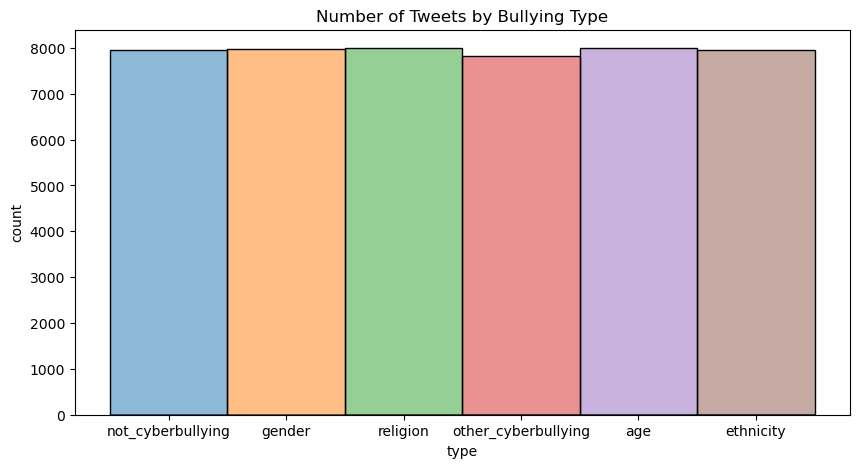

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))
plot = sns.histplot(data=df,x='type', hue='type', legend=False)
plot.set(xlabel='type',ylabel='count', title='Number of Tweets by Bullying Type')
plt.show()


The number of tweets for each category are around the same so we do not need to worry about problems that arise with imbalanced datasets.

In [5]:
#plot lengths of texts
df['len'] = df['text'].str.len()


df['len'].describe()

count    47692.000000
mean       136.253229
std         85.226899
min          1.000000
25%         78.000000
50%        124.000000
75%        180.000000
max       5018.000000
Name: len, dtype: float64

[Text(0.5, 1.0, 'Tweet Length by Bullying Type'),
 Text(0.5, 0, 'Bullying Type'),
 Text(0, 0.5, 'Character Length')]

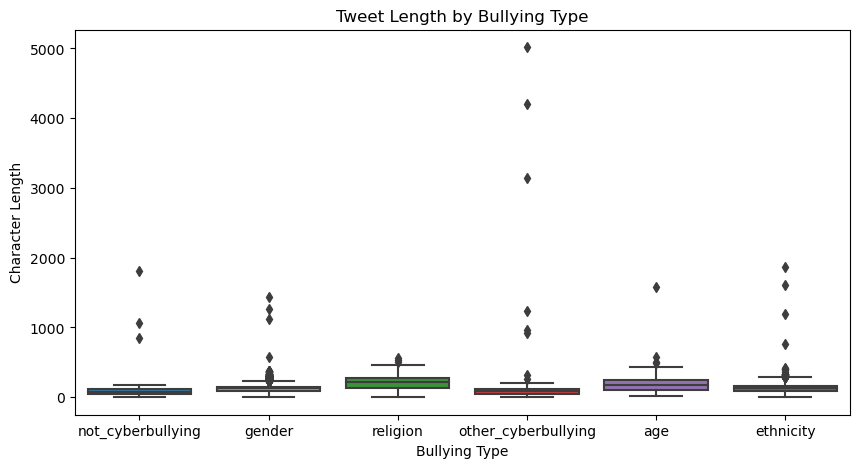

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
plot = sns.boxplot(data=df, y='len', x='type')
plot.set(title='Tweet Length by Bullying Type',
       xlabel='Bullying Type',
       ylabel='Character Length')


The length of text is around the same for all of our categories with the more extreme outliers focused in the other_cyberbullying categories. Length outliers could potentially lead our model astray so it would be beneficial to remove the outliers using the code below:

In [7]:
IQR = 180 - 78
outlier_threshold = 180 + (1.5 * IQR)

#remove outliers

df = df[df['len'] < outlier_threshold]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47609 entries, 0 to 47691
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    47609 non-null  object
 1   type    47609 non-null  object
 2   len     47609 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


We can see that after outlier removal, we are left with 47,609 tweets for analysis.

[Text(0.5, 0, 'Length of Tweet (in characters)'), Text(0, 0.5, 'Count')]

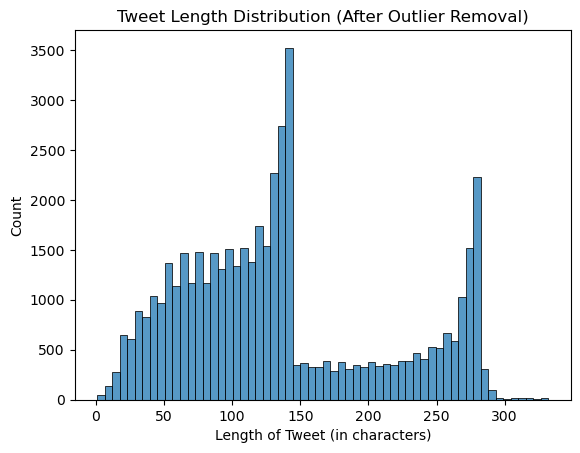

In [8]:
plot = sns.histplot(data=df, x='len')
plot.set_title('Tweet Length Distribution (After Outlier Removal)')
plot.set(xlabel='Length of Tweet (in characters)', ylabel='Count')

### Understanding other_cyberbullying

other_cyberbullying is somewhat of a complicated category as it is by definition more amorphous than the other categories of cyberbullying. We can better understand the nature of this category by viewing its associated tweets.

In [9]:
other = df[df['type'] == 'other_cyberbullying']

for tweet in other['text'].head(10):
    print(tweet)

@ikralla fyi, it looks like I was caught by it. I'm not a botter, so...
I need to just switch to an organization-based github, but I don't want to pay $25/month because I'm cheap. :\
RMAed my monoprice. Shoddy power bricks on those. Getting a refund and picking up another ASUS VG278HE. It's cheaper, anyways.
@murphy_slaw https://t.co/M8w8xnUnDL
@1Life0Continues i've got the code to interpret &amp; analyze, but the weights themselves are going to take a lot of fiddling.
@krainboltgreene didn't mention your name. i call out behavior, not people. &lt;3
RT @exokmv: i swear people are so fucking ignorant and annoying
Yeah, I've got a bit of a rageboner. Mentally speaking.
RT @Laralyn: Uh... wow. https://t.co/CdoNLaApVr
The morning after, hung over, struggling to remember how that pile of o'reilly books ended up in your bed. "WHAT DID I CODE LAST NIGHT"


The examples above are indeed amorphous and seem to require more context to understand the cyberbullying aspect. It is likely that other_cyberbullying may be difficult for the model to generalize on without access to the context of the tweets themselves to train on. We can still see if the RNN is able to find relationships to model for this category.

## Data Preprocessing

In order to feed the training data to an RNN we will need to one-hot encode our category labels, perform standard NLP preprocessing such as removing stop words and punctuation, converting words to tokens, vectorizing strings, and embedding those vectors. 


In [10]:
# hot_encode the category labels
lab_enc = LabelEncoder()

lab_enc.fit(df['type'].unique())
#transform labels to integer encoding
encoded_type = lab_enc.transform(df['type'])
#transform integer encoding to one hot encoding
y_encoded = tf.keras.utils.to_categorical(encoded_type)

In [11]:
## Remove stop words from tweets

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    """
    Utility function to remove stopwords from string.
    Returns string with stopwords removed.
    """
    
    split_text = text.split(" ")
    removed = [word for word in split_text if word.lower() not in stop_words]
    recreated = " ".join(removed) #rejoin
    
    return recreated
    
df['text'] = df['text'].apply(remove_stopwords)



In [12]:
#split training data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], y_encoded, test_size=0.2)

X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.2)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [13]:
BUFFER_SIZE = 100000 #larger than total tweets
BATCH_SIZE = 64

#batch and shuffle training dataset
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Content Warning

The below code samples from the dataset to confirm the above preprocessing steps were successful. This may result in offensive language being printed below including slurs.

In [14]:
#confirm the dataset has been created and batched correctly

for example, label in train_ds.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b"@Makofury glad could help, I'm sorry going that. :("
 b'middle school name people used bully \xe2\x80\x9cJake Mattern-ity leave\xe2\x80\x9d yes, that\xe2\x80\x99s really clever sixth grade also implies there\xe2\x80\x99s shame caring newborn child. better name would fecal Mattern dumb fucks.'
 b'Cigany nigger took keys volvo fucking haram idiot forgot take car nigger dumb fuck cigan']

labels:  [[0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


## Text Preprocessing & Vectorization

We will use Keras's Text Vectorization layer to perform standard cleaning and vectorization. 

In order to properly clean tweets we will be removing any username tags (e.g. @twittername) as they are irrelevant to our analysis. Additionally we will remove punctuation and URLs. We removed common English stop words in a previous step so we do not need to do so here. 

In [15]:
vocab_size = 15000 #max size of vocabulary

def custom_standardize(input_data):
    lowercase = tf.strings.lower(input_data)
    remove_user_tags = tf.strings.regex_replace(lowercase, '@\S+', '')
    remove_urls = tf.strings.regex_replace(remove_user_tags, 'http[s]?://\S*', '')

    return remove_urls


encoder = TextVectorization(max_tokens=vocab_size,
                           standardize=custom_standardize)

#adapt the text vectorization layer to full content of tweets
encoder.adapt(train_ds.map(lambda text, label: text))

In [16]:
#Confirm encoder correctly vectorizes the text

for example, label in train_ds.take(1):
    example = encoder(example)
    print('encoded texts: ', example.numpy()[:3])
    print('')
    print('labels: ', label.numpy()[:3])

encoded texts:  [[    1   606   175   711 12311   726  5074   245     1     1     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0]
 [ 4819   264     1    91  1506    48   256  1796     1   406   963  1027
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0]
 [   10   306    93    73   255   335   633   291    52  2392     1   502
   1934   229   186    10  3091    29    85    54   231  1123    73   173
    255   148     1    10   110 10231     0     0     0]]

labels:  [[0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]


## Evaluating RNN for Classification Task


In [17]:
early_stopping = EarlyStopping(patience=3, #early stopping if val_loss worsens <patience> number of times.
                        restore_best_weights=True) #restores the weights from the best iteration during training

num_categories = len(df['type'].unique())


### Building LSTM Model for Classification


In [18]:
lstm = Sequential(name='LSTM')
lstm.add(encoder) #add vectorizer layer to model
lstm.add(Embedding(input_dim=vocab_size, 
                     output_dim=64, 
                     mask_zero=True)) #Masking zero allows for the model to handle varying sequence length
lstm.add(Bidirectional(LSTM(128,
                dropout=.2,
                recurrent_dropout=.1,
                return_sequences=True)))
lstm.add(Bidirectional(LSTM(128,
                dropout=.2,
                recurrent_dropout=.1)))
lstm.add(Dense(128, activation='relu'))
lstm.add(Dropout(.2))
lstm.add(Dense(64, activation='relu'))
lstm.add(Dense(num_categories, activation='softmax'))

lstm.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 64)          960000    
                                                                 
 bidirectional (Bidirection  (None, None, 256)         197632    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                              

In [19]:
opt = Adam(learning_rate=0.001)

lstm.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [20]:
#Train the model
lstm_history = lstm.fit(train_ds, epochs=30,
                    validation_data=val_ds,
                    validation_steps=1,
                    callbacks=[early_stopping],
                    verbose=1)


Epoch 1/30
477/477 [==============================] - 102s 195ms/step - loss: 0.7030 - accuracy: 0.7039 - val_loss: 0.4578 - val_accuracy: 0.8438
Epoch 2/30
477/477 [==============================] - 92s 194ms/step - loss: 0.3836 - accuracy: 0.8405 - val_loss: 0.4890 - val_accuracy: 0.7812
Epoch 3/30
477/477 [==============================] - 93s 194ms/step - loss: 0.2946 - accuracy: 0.8811 - val_loss: 0.6502 - val_accuracy: 0.7188
Epoch 4/30
477/477 [==============================] - 94s 197ms/step - loss: 0.2430 - accuracy: 0.9033 - val_loss: 0.5164 - val_accuracy: 0.7969


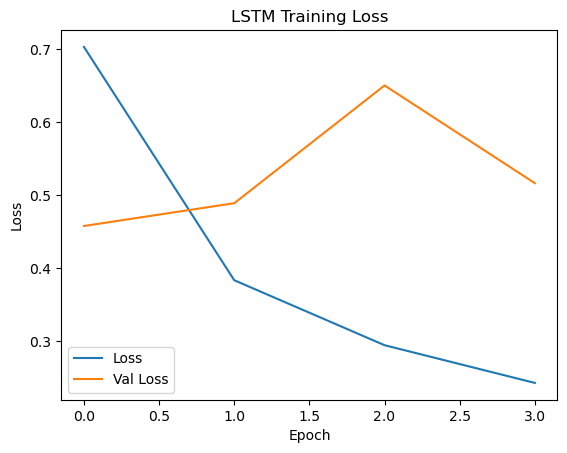

In [21]:
plt.plot(lstm_history.history['loss'], label='Loss')
plt.plot(lstm_history.history['val_loss'], label = 'Val Loss')
plt.title('LSTM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower left')

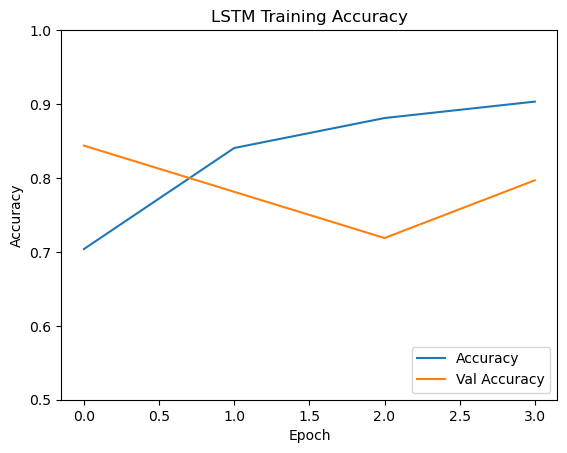

In [22]:
plt.plot(lstm_history.history['accuracy'], label='Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label = 'Val Accuracy')
plt.title('LSTM Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


We can see from the visualized training information above that the validation loss increases and diverges from the training loss after a certain amount of epochs which is a classic sign that the model is overfitting.  

## Gated Recurrent Units (GRUs) for Multiclassification

In [23]:
gru = Sequential(name='GRU')
gru.add(encoder) #add vectorizer layer to model
gru.add(Embedding(input_dim=vocab_size, 
                     output_dim=64, 
                     mask_zero=True)) #Masking zero allows for the model to handle varying sequence length
gru.add(GRU(128, 
            dropout=.2,
            recurrent_dropout=.1,
            return_sequences=True))
gru.add(GRU(64,
           dropout=.1,
           recurrent_dropout=.1))
gru.add(Dense(128, activation='relu'))
gru.add(Dropout(.2))
gru.add(Dense(64, activation='relu'))
gru.add(Dense(num_categories, activation='softmax'))

gru.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          960000    
                                                                 
 gru (GRU)                   (None, None, 128)         74496     
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                               

In [24]:
opt = Adam(learning_rate=0.001)

gru.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [25]:
#Train the model
gru_history = gru.fit(train_ds, epochs=30,
                    validation_data=val_ds,
                    validation_steps=1,
                    callbacks=[early_stopping],
                    verbose=1)


Epoch 1/30
477/477 [==============================] - 30s 53ms/step - loss: 0.7611 - accuracy: 0.6657 - val_loss: 0.7197 - val_accuracy: 0.6719
Epoch 2/30
477/477 [==============================] - 25s 52ms/step - loss: 0.4218 - accuracy: 0.8216 - val_loss: 0.4923 - val_accuracy: 0.8750
Epoch 3/30
477/477 [==============================] - 25s 51ms/step - loss: 0.3318 - accuracy: 0.8640 - val_loss: 0.6276 - val_accuracy: 0.8438
Epoch 4/30
477/477 [==============================] - 25s 52ms/step - loss: 0.2768 - accuracy: 0.8900 - val_loss: 0.2863 - val_accuracy: 0.8750
Epoch 5/30
477/477 [==============================] - 25s 52ms/step - loss: 0.2361 - accuracy: 0.9055 - val_loss: 0.4147 - val_accuracy: 0.8594
Epoch 6/30
477/477 [==============================] - 25s 53ms/step - loss: 0.2080 - accuracy: 0.9154 - val_loss: 0.8944 - val_accuracy: 0.7500
Epoch 7/30
477/477 [==============================] - 27s 55ms/step - loss: 0.1806 - accuracy: 0.9253 - val_loss: 0.5122 - val_accuracy:

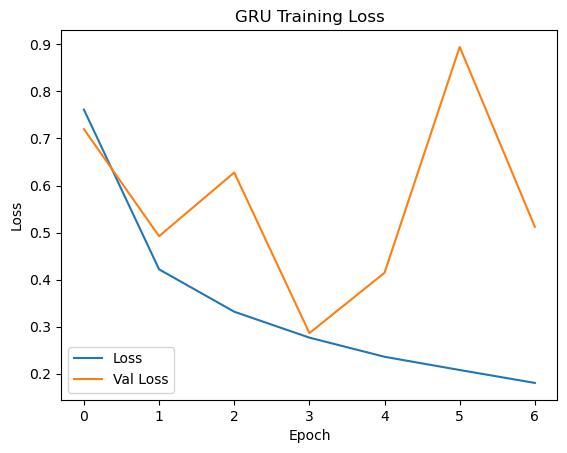

In [26]:
plt.plot(gru_history.history['loss'], label='Loss')
plt.plot(gru_history.history['val_loss'], label = 'Val Loss')
plt.title('GRU Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower left')

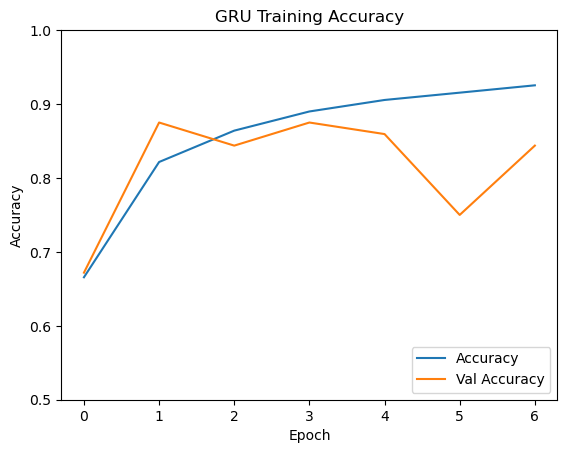

In [27]:
plt.plot(gru_history.history['accuracy'], label='Accuracy')
plt.plot(gru_history.history['val_accuracy'], label = 'Val Accuracy')
plt.title('GRU Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


Similarly to the LSTM, the GRU network also appears to overfit on the training data even with dropout layers in the model.

## Comparing Models on Validation Data

In [46]:
#Predict
softmax_prediction = lstm.predict(X_val)
y_prediction = np.argmax(softmax_prediction, axis=1)
y_val_single = np.argmax(y_val, axis=1) #remove one hot encoding


239/239 [==============================] - 5s 19ms/step


In [47]:
precision = precision_score(y_val_single, y_prediction, average='macro')
recall = recall_score(y_val_single, y_prediction, average='macro')
accuracy = accuracy_score(y_val_single, y_prediction)
f1_score = sklearn.metrics.f1_score(y_val_single, y_prediction, average='macro')

metrics = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1_Score"])

metrics.loc['LSTM'] = [accuracy, precision, recall, f1_score]

metrics

,Accuracy,Precision,Recall,F1_Score
LSTM,0.809661,0.817378,0.80851,0.807366


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0, 0.5, 'age'),
  Text(0, 1.5, 'ethnicity'),
  Text(0, 2.5, 'gender'),
  Text(0, 3.5, 'not_cyberbullying'),
  Text(0, 4.5, 'other_cyberbullying'),
  Text(0, 5.5, 'religion')])

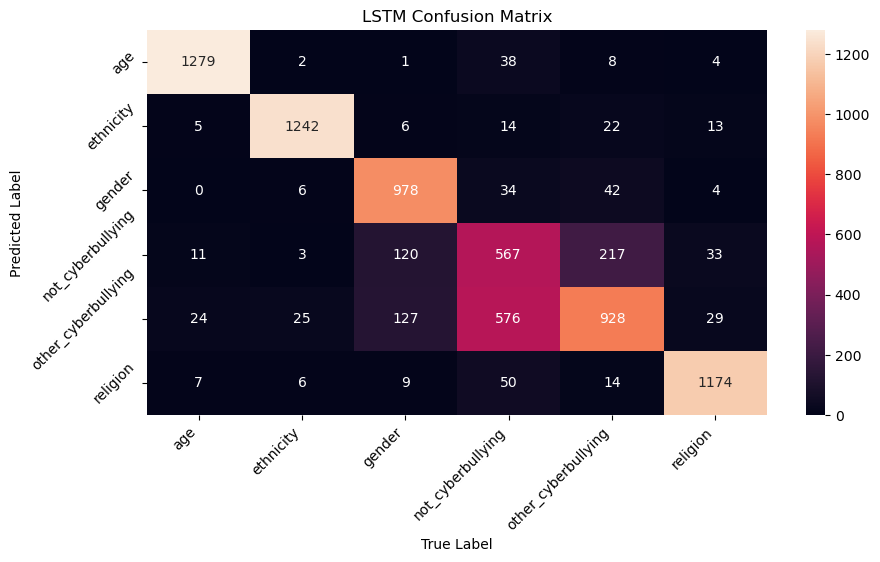

In [48]:
categories = lab_enc.inverse_transform([0,1,2,3,4,5])

conf = confusion_matrix(y_prediction, y_val_single)

fig, ax = plt.subplots(figsize=(10, 5))

sns.heatmap(conf, annot=True, fmt='1g').set(
    title='LSTM Confusion Matrix',
    xlabel = 'True Label',
    ylabel = 'Predicted Label',
    xticklabels = categories,
    yticklabels = categories,
    
)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')

In spite of the overfitting we saw in training, we can see that the LSTM model performs pretty well on the validation data. The confusion matrix shows good success for all categories except for not_cyberbullying and other_cyberbullying. In particular, it appears that the model has some difficulty differentiating between the two. This is likely due to the aforementioned amorphous and context-required nature of some of the other_cyberbullying examples. In comparison, cyber bullying targeting ethnicity, age, gender, and religion were more straightforward for the model to discern.

In [49]:
#Predict
softmax_prediction = gru.predict(X_val)
y_prediction = np.argmax(softmax_prediction, axis=1)
y_val_single = np.argmax(y_val, axis=1) #remove one hot encoding


239/239 [==============================] - 2s 7ms/step


In [50]:
gru_precision = precision_score(y_val_single, y_prediction, average='macro')
gru_recall = recall_score(y_val_single, y_prediction, average='macro')
gru_accuracy = accuracy_score(y_val_single, y_prediction)
gru_f1_score = sklearn.metrics.f1_score(y_val_single, y_prediction, average='macro')

metrics.loc['GRU'] = [gru_accuracy, gru_precision, gru_recall, gru_f1_score]

metrics

,Accuracy,Precision,Recall,F1_Score
LSTM,0.809661,0.817378,0.80851,0.807366
GRU,0.795353,0.799062,0.79385,0.794186


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0, 0.5, 'age'),
  Text(0, 1.5, 'ethnicity'),
  Text(0, 2.5, 'gender'),
  Text(0, 3.5, 'not_cyberbullying'),
  Text(0, 4.5, 'other_cyberbullying'),
  Text(0, 5.5, 'religion')])

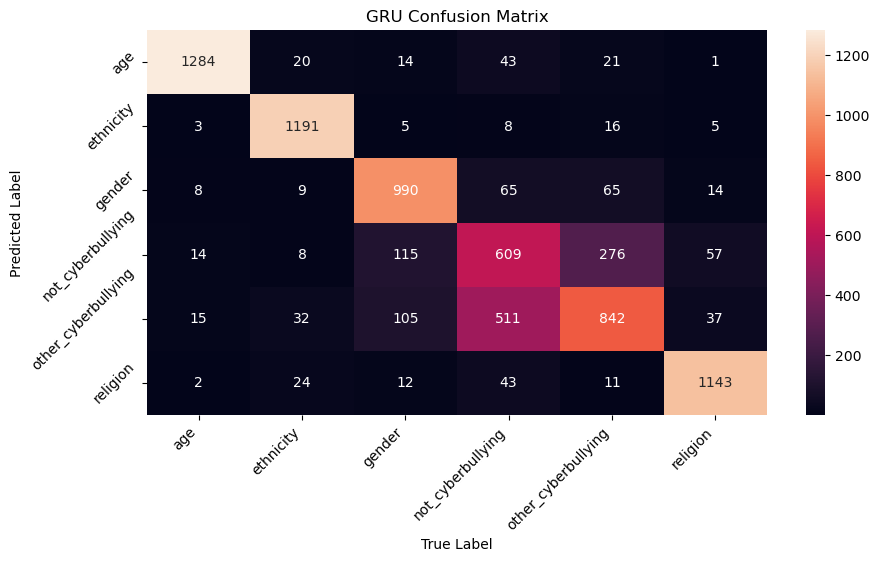

In [51]:
categories = lab_enc.inverse_transform([0,1,2,3,4,5])

conf = confusion_matrix(y_prediction, y_val_single)

fig, ax = plt.subplots(figsize=(10, 5))

sns.heatmap(conf, annot=True, fmt='1g').set(
    title='GRU Confusion Matrix',
    xlabel = 'True Label',
    ylabel = 'Predicted Label',
    xticklabels = categories,
    yticklabels = categories,
    
)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')

The GRU model performs similarly to the LSTM model with the same hurdles differentiating not_cyberbullying and other_cyberbullying. 

A major advantage of the GRU model is that it requires much less overhead than the LSTM model and is able to train faster. Because of this, it is an ideal canditate for architecture and hyperparameter tuning using the keras_tuner library in order to find the ideal hyperparameters and architecture to optimize the model's accuracy.

## Improving the GRU Model with Hyperparameter Tuning

In [52]:
def build_model(hp):
    """
    Function to tune a GRU model using the keras_tuner library
    and conditional hyperparameters.
    """
    model = Sequential(name='GRU_tuned')
    model.add(encoder) #add vectorizer layer to model
    model.add(Embedding(input_dim=vocab_size, 
                     output_dim=64, 
                     mask_zero=True)) #
    
    if hp.Boolean("second_GRU_layer"):
                
        model.add(GRU(units=hp.Int(f"first_GRU_units", min_value=64, max_value=512, step=32), 
                dropout=hp.Float("first_GRU_dropout",min_value=.05, max_value=.3),
                recurrent_dropout=hp.Float("first_GRU_rec_dropout", min_value=.05, max_value=.3),
                return_sequences=True))

        with hp.conditional_scope("second_GRU_layer", True):

            model.add(GRU(units=hp.Int(f"second_GRU_units", min_value=32, max_value=512, step=32),
                   dropout=hp.Float("second_GRU_dropout",min_value=.05, max_value=.3),
                   recurrent_dropout=hp.Float("second_GRU_rec_dropout",min_value=.05, max_value=.3)
                ))
            
    else:
        
        model.add(GRU(units=hp.Int(f"first_GRU_units", min_value=64, max_value=512, step=32), 
                dropout=hp.Float("first_GRU_dropout",min_value=.05, max_value=.5),
                recurrent_dropout=hp.Float("first_GRU_rec_dropout", min_value=.05, max_value=.5)
                ))
    
    if hp.Boolean("first_dropout"):
        with hp.conditional_scope("first_dropout", True):
            model.add(Dropout(rate=hp.Float("first_dropout_rate", min_value=.05, max_value=.5)))
        
    #Add 1-2 Dense Layers
    for i in range(hp.Int("num_layers", 1, 2)):
        
        if hp.Boolean("inter_drop"):
            with hp.conditional_scope("inter_drop", True):
                if i > 1: #only add dropout between dense layers
                    model.add(Dropout(rate=hp.Float("inter_dropout_rate", min_value=.05, max_value=.5)))
                
        model.add(
            Dense(
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
        
    
    if hp.Boolean("final_dropout"):
        with hp.conditional_scope("final_dropout", True):
            model.add(Dropout(rate=hp.Float("final_dropout_rate", min_value=.05, max_value=.5)))
        
    model.add(Dense(num_categories, activation='softmax'))
    
    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    return model

In [53]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    max_trials = 20,
    overwrite=True,
    objective="val_accuracy",
    directory="./",
    project_name="gru_tuning",
)

tuner.search_space_summary()

Search space summary
Default search space size: 11
second_GRU_layer (Boolean)
{'default': False, 'conditions': []}
first_GRU_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
first_GRU_dropout (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}
first_GRU_rec_dropout (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}
first_dropout (Boolean)
{'default': False, 'conditions': []}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
inter_drop (Boolean)
{'default': False, 'conditions': []}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
final_dropout (Boolean)


In [54]:
### Perform the search over the hyperparameter space

tuner.search(train_ds, 
             epochs=10,
             validation_data=val_ds,
             callbacks=[EarlyStopping(monitor='val_loss', patience=1)]
            )

Trial 20 Complete [00h 02m 37s]
val_accuracy: 0.8206878304481506

Best val_accuracy So Far: 0.8206878304481506
Total elapsed time: 01h 41m 53s


In [55]:
## Retrieve summary of all trials 

tuner.results_summary()

Results summary
Results in ./gru_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 19 summary
Hyperparameters:
second_GRU_layer: False
first_GRU_units: 352
first_GRU_dropout: 0.12802243952390782
first_GRU_rec_dropout: 0.06465927299904468
first_dropout: True
num_layers: 1
inter_drop: True
units_0: 32
activation: relu
final_dropout: False
lr: 0.0034818688017796847
first_dropout_rate: 0.45216559223254554
units_1: 480
Score: 0.8206878304481506

Trial 05 summary
Hyperparameters:
second_GRU_layer: False
first_GRU_units: 320
first_GRU_dropout: 0.30740911602132776
first_GRU_rec_dropout: 0.2978480358798859
first_dropout: False
num_layers: 1
inter_drop: True
units_0: 32
activation: relu
final_dropout: False
lr: 0.0069405535544335905
units_1: 64
Score: 0.8199002146720886

Trial 02 summary
Hyperparameters:
second_GRU_layer: True
first_GRU_units: 288
first_GRU_dropout: 0.41407453470773287
first_GRU_rec_dropout: 0.3125107351903257
first_dropout: False
num_layers: 2

In [56]:
## Retrieve the best model from keras tuner

models = tuner.get_best_models(num_models=1)
best_model = models[0]
best_model.summary()

Model: "GRU_tuned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 64)          960000    
                                                                 
 gru (GRU)                   (None, 352)               441408    
                                                                 
 dropout (Dropout)           (None, 352)               0         
                                                                 
 dense (Dense)               (None, 32)                11296     
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                         

In [57]:
#Predict
softmax_prediction = best_model.predict(X_val)
y_prediction = np.argmax(softmax_prediction, axis=1)
y_val_single = np.argmax(y_val, axis=1) #remove one hot encoding


239/239 [==============================] - 6s 22ms/step


In [58]:
precision = precision_score(y_val_single, y_prediction, average='macro')
recall = recall_score(y_val_single, y_prediction, average='macro')
accuracy = accuracy_score(y_val_single, y_prediction)
f1_score = sklearn.metrics.f1_score(y_val_single, y_prediction, average='macro')

metrics.loc['tuned_GRU'] = [accuracy, precision, recall, f1_score]

metrics

,Accuracy,Precision,Recall,F1_Score
LSTM,0.809661,0.817378,0.808510,0.807366
GRU,0.795353,0.799062,0.793850,0.794186
tuned_GRU,0.820688,0.819726,0.819206,0.818227


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0, 0.5, 'age'),
  Text(0, 1.5, 'ethnicity'),
  Text(0, 2.5, 'gender'),
  Text(0, 3.5, 'not_cyberbullying'),
  Text(0, 4.5, 'other_cyberbullying'),
  Text(0, 5.5, 'religion')])

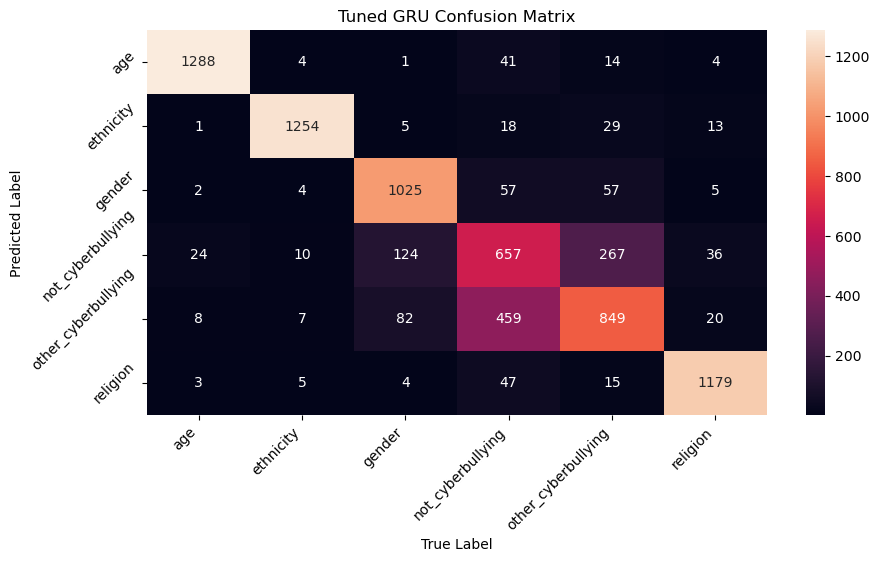

In [59]:
categories = lab_enc.inverse_transform([0,1,2,3,4,5])

conf = confusion_matrix(y_prediction, y_val_single)

fig, ax = plt.subplots(figsize=(10, 5))

sns.heatmap(conf, annot=True, fmt='1g').set(
    title='Tuned GRU Confusion Matrix',
    xlabel = 'True Label',
    ylabel = 'Predicted Label',
    xticklabels = categories,
    yticklabels = categories,
    
)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')

As expected, the tuned GRU model performs better than all previous models on the validation data but still experiences some hurdles related to not_cyberbullying and other_cyberbullying differentiation. 

## Evaluating the Models on Test Data

We can now test all three models on the test data to evaluate which model generalizes the best for our multiclassification objective.

In [60]:
#Predict LSTM
softmax_prediction = lstm.predict(X_val)
y_prediction = np.argmax(softmax_prediction, axis=1)
y_val_single = np.argmax(y_val, axis=1) #remove one hot encoding


precision = precision_score(y_val_single, y_prediction, average='macro')
recall = recall_score(y_val_single, y_prediction, average='macro')
accuracy = accuracy_score(y_val_single, y_prediction)
f1_score = sklearn.metrics.f1_score(y_val_single, y_prediction, average='macro')

test_metrics = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1_Score"])

test_metrics.loc['LSTM'] = [accuracy, precision, recall, f1_score]

239/239 [==============================] - 5s 21ms/step


In [61]:
#Predict GRU
softmax_prediction = gru.predict(X_val)
y_prediction = np.argmax(softmax_prediction, axis=1)
y_val_single = np.argmax(y_val, axis=1) #remove one hot encoding

precision = precision_score(y_val_single, y_prediction, average='macro')
recall = recall_score(y_val_single, y_prediction, average='macro')
accuracy = accuracy_score(y_val_single, y_prediction)
f1_score = sklearn.metrics.f1_score(y_val_single, y_prediction, average='macro')

test_metrics.loc['GRU'] = [accuracy, precision, recall, f1_score]

239/239 [==============================] - 2s 8ms/step


In [62]:
#Predict tuned_GRU

softmax_prediction = best_model.predict(X_val)
y_prediction = np.argmax(softmax_prediction, axis=1)
y_val_single = np.argmax(y_val, axis=1) #remove one hot encoding

precision = precision_score(y_val_single, y_prediction, average='macro')
recall = recall_score(y_val_single, y_prediction, average='macro')
accuracy = accuracy_score(y_val_single, y_prediction)
f1_score = sklearn.metrics.f1_score(y_val_single, y_prediction, average='macro')

metrics.loc['tuned_GRU'] = [accuracy, precision, recall, f1_score]

metrics

239/239 [==============================] - 5s 22ms/step


,Accuracy,Precision,Recall,F1_Score
LSTM,0.809661,0.817378,0.808510,0.807366
GRU,0.795353,0.799062,0.793850,0.794186
tuned_GRU,0.820688,0.819726,0.819206,0.818227


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0, 0.5, 'age'),
  Text(0, 1.5, 'ethnicity'),
  Text(0, 2.5, 'gender'),
  Text(0, 3.5, 'not_cyberbullying'),
  Text(0, 4.5, 'other_cyberbullying'),
  Text(0, 5.5, 'religion')])

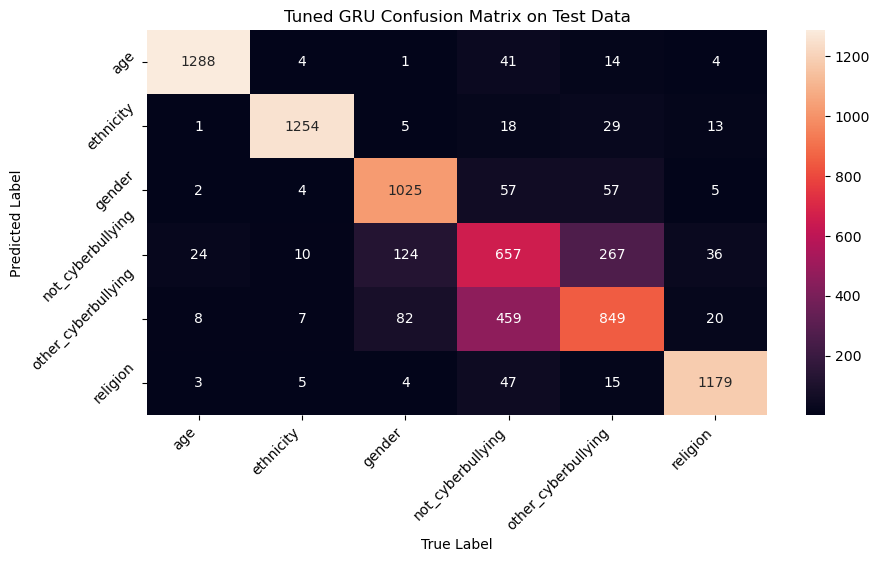

In [63]:
categories = lab_enc.inverse_transform([0,1,2,3,4,5])

conf = confusion_matrix(y_prediction, y_val_single)

fig, ax = plt.subplots(figsize=(10, 5))

sns.heatmap(conf, annot=True, fmt='1g').set(
    title='Tuned GRU Confusion Matrix on Test Data',
    xlabel = 'True Label',
    ylabel = 'Predicted Label',
    xticklabels = categories,
    yticklabels = categories,
    
)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')

# Conclusions



The tuned GRU model performs the best in all four metrics, scoring the highest Accuracy, Precision, Recall, and F1 Score on the test data. With an accuracy of approximately 82% the GRU model could be used in production to help flag potential cyber bullying on twitter for moderators to review. The categorization of cyber bullying into 5 classes may allow for domain-specific moderators to intervene or analyze the texts ensuring that the ideal staff person is flagged.

## Future Improvements

The hyperparameter tuning favored a simple architecture with only a single GRU layer and Dense layer. Future tuning could attempt to limit threshold ranges to see if any futher optimizations might be made.

The biggest difficulty the model has is differentiating the other_cyberbullying category from not_cyberbullying. One potential method to improve the differentiability of that category is to train another model on the binary classification problem of cyberbullying vs not_cyberbullying and then use it in an ensemble with our own model. Our own model could flag potential cyberbullying and, in the case of a certain threshold for other_cyberbullying or not_cyberbullying the second model could then provide a failsafe to lower the probability of a false negative or positive. 

It may benefit the model to have additional parameters to learn from including: the tweet being responded to, location data, and bios. In particular, this additional information may help the model parse instances of other_cyberbullying which relies on additional context and improve performance.